<div class="alert alert-success">
<h1>Container glass model - MORDM approach</h1>

<h4>Thesis title: *"Decarbonisation of the Container glass industry by 2050: A model-based analysis of technology options"*</h4>
<h4>Ioannis Papadogeorgos, Student No. 4737296</h4>
<h4>MSc Engineering & Policy Analysis, TU Delft</h4>

<div class="alert alert-success">
<h1>1. Model specification</h1>

Here we create an ema_workbench interface for this problem. In practice, the glass_model function is the "system model". Any given parameterization of the decision levers is known as a policy, while any given parametrization over the uncertainties is known as a scenario.

Important to notice that the decision levers do not implicate with others, because of the absence of time scale or cyclical loops in the Excel model. In reality, a waste heat recovery option decreases the fuel consumption and, as a consequence, decreases the available flue gas to be recovered. Decreased residual heat would mean that other options are now excluded. Here, we only show the impact of a technology to the process, rather than adapting the model to the new conditions.

Decision levers:
**Ratio NG** (i.e. percentage of Natural gas out of total primary fuel used); **O2 Substitution** (i.e. percentage of pure oxygen replacing atmpospheric air for combusting natural gas); **Glass Type** (1: Flint, 2: Amber, 3: Emerald); **Bio_switch** (i.e. switch from Natural gas to Biomethane); **Technology** (0-9) as follows:

* 0: Regenerative furnace 
* 1: Regenerative furnace with batch preheater
* 2: Oxy/fuel furnace
* 3: Oxy/fuel furnace with Batch/cullet preheater
* 4: Oxy/fuel furnace with NG/O2 preheater
* 5: Oxy/fuel furnace with Batch/cullet and NG/O2 preheater
* 6: Optimelt TCR furnace
* 7: Optimelt TCR furnace with Batch/cullet preheater
* 8: Optimelt PLUS furnace
* 9: Electric furnace

In [1]:
# import EMA libraries

from ema_workbench.connectors.excel import ExcelModel
from ema_workbench import (RealParameter, IntegerParameter, ScalarOutcome, Constraint, perform_experiments,
                           MultiprocessingEvalauator, SequentialEvaluator, ema_logging, Policy)
from ema_workbench.em_framework.optimization import (EpsilonProgress, HyperVolume, Convergence)
from ema_workbench.em_framework.evaluators import BaseEvaluator

In [2]:
from __future__ import (unicode_literals, print_function, absolute_import, division)

from ema_workbench.em_framework.samplers import sample_uncertainties, sample_levers
from ema_workbench import save_results, load_results, Policy, Scenario
from ema_workbench.em_framework.evaluators import LHS
from ema_workbench.analysis import parcoords, prim, feature_scoring, dimensional_stacking
import ema_workbench.analysis.scenario_discovery_util
import numpy.lib.recfunctions as rf

C:\ProgramData\Anaconda3\lib\site-packages\ema_workbench\analysis\prim.py:31: ImportWarning: altair based interactive inspection not available
  "inspection not available"), ImportWarning)
C:\ProgramData\Anaconda3\lib\importlib\_bootstrap_external.py:426: ImportWarning: Not importing directory C:\ProgramData\Anaconda3\lib\site-packages\mpl_toolkits: missing __init__
  _warnings.warn(msg.format(portions[0]), ImportWarning)
C:\ProgramData\Anaconda3\lib\importlib\_bootstrap_external.py:426: ImportWarning: Not importing directory c:\programdata\anaconda3\lib\site-packages\mpl_toolkits: missing __init__
  _warnings.warn(msg.format(portions[0]), ImportWarning)


In [3]:
import statsmodels.api as sm
import itertools
from math import pi
from collections import defaultdict
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
#from pandas import datetools
import scipy
import functools
#import mpld3
import plotly.plotly as py
import plotly.graph_objs as go

%matplotlib inline 
#%matplotlib notebook
#from labellines import *

sns.set_style("whitegrid") # Change plot style

In [4]:
# Define system model
glass_model = ExcelModel("excelmodel", wd="./Model", model_file='Glass_MORDM.xlsx')

# Locate the Excel sheet
glass_model.default_sheet = "Global"

# Specification of uncertainties
glass_model.uncertainties = [RealParameter('NG_price', 0.038, 0.06),
                       RealParameter('Electricity_price', 0.03, 0.0793),
                       IntegerParameter('CO2_price', 18, 60),
                       RealParameter('O2_price', 0.05, 0.1), 
                       #RealParameter('Bio_price', 0.5, 0.9),      
                       RealParameter('Emission_factor', 0, 0.5),   
                       RealParameter('Losses_factor', 1, 1.05),
                       RealParameter('Effic_factor', 0.95, 1.05),
                       RealParameter('Cullet_factor', 0.8, 1.25)             
                       ]

# Specification of levers
glass_model.levers = [IntegerParameter('Technology', 0, 9),
                  IntegerParameter('O2_substitution', 0, 60),
                  IntegerParameter('Ratio_NG', 75, 99)
                  #IntegerParameter('Glass_type', 1, 3),        
                  #IntegerParameter('Bio_switch', 0, 1)               
                  ]     
                                                                   
# Specification of outcomes
glass_model.outcomes = [ScalarOutcome("Direct_CO2", kind=ScalarOutcome.MINIMIZE),
                  ScalarOutcome("Indirect_CO2", kind=ScalarOutcome.MINIMIZE),
                  ScalarOutcome("Energy_use", kind=ScalarOutcome.MINIMIZE),
                  #ScalarOutcome("Glass_Pull", kind=ScalarOutcome.MAXIMIZE),
                  ScalarOutcome("Product_cost", kind=ScalarOutcome.MINIMIZE),
                  ScalarOutcome("ROI", kind=ScalarOutcome.MAXIMIZE),
                  ScalarOutcome("Payback", kind=ScalarOutcome.MINIMIZE)      
                  ]

In [5]:
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

<div class="alert alert-success">
<h1>2. Policy Alternative Determination</h1>

In the second step of MORDM, candidate strategies are identified which are pareto-optimal conditional on a reference scenario using the optimization functionality of the workbench. These candidate strategies are identified through search with many-objective evolutionary algorithms, that iteratively evaluate a large number of alternatives on various objectives until they find the best candidates. The model function (i.e.  model interface developed in the previous step) will be called for each candidate evaluation, and the corresponding four performance measures will be generated.

The focus is on applying search to find promising candidate strategies by searching through the lever space. A low epsilon value is set for getting more solutions in the pareto approximate set, while a  higher number of function evaluations helps the optimisation to better converge. Hence, more solutions are expected for a finer (i.e. lower) scan of the outcome space. 

For hypervolume, I need to make sure that the maximum the large enough so that I know that the pareto approximate set will  have points within the end dimensional space (where the hypercude spans). The limits for HV are the preferred goals (adjust them if I get a flat graph).

In [ ]:
# Set a reference scenario
reference = Scenario('reference', Electricity_price=0.0793, NG_price=0.038, 
                     CO2_price=25, O2_price=0.06, Cullet_factor=1, 
                     Emission_factor=0.48, Losses_factor=1, Effic_factor=1)          

# Track convergence
convergence_value = [EpsilonProgress(), HyperVolume(minimum=[0,0,0,0,0,0],              
                     maximum=[220,150,4.5,6.5,20,2])]                                                

# Search over levers
with MultiprocessingEvaluator(glass_model) as evaluator:
 
        results, convergence = evaluator.optimize(nfe=25000, searchover='levers',
                                     epsilons=[0.01,]*len(glass_model.outcomes),
                                     convergence=convergence_value,
                                     reference=reference)     

In [ ]:
# Track convergence

fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4)) 
ax1.plot(convergence.nfe, convergence.epsilon_progress)               
ax1.set_ylabel('$\epsilon$-progress')                                 
ax2.plot(convergence.nfe, convergence.hypervolume)                    
ax2.set_ylabel('hypervolume')                                         

ax1.set_xlabel('Number of function evaluations (nfe)')
ax2.set_xlabel('Number of function evaluations (nfe)')

# Remove the top and left hand black outline of axes
sns.despine()

plt.subplots_adjust(wspace = .5)
plt.show()  

In [ ]:
results.to_csv("Container_glass_25e3.csv")

In [7]:
# Show the most promising solutions, as extracted from the optimization above.

results_optimize_MORDM = pd.read_csv('Container_glass_25e3.csv')
results_optimize_MORDM.drop(results_optimize_MORDM.iloc[:, [0]], axis=1, inplace=True)
results_optimize_MORDM=round(results_optimize_MORDM, 2)
#results_optimize_MORDM.drop([39], inplace=True)
#results_optimize_MORDM.reset_index(inplace=True, drop=True)
results_optimize_MORDM

,Technology,O2_substitution,Ratio_NG,Direct_CO2,Indirect_CO2,Energy_use,Product_cost,ROI,Payback
0,5,55,84,192.57,24.46,3.35,5.07,11.92,2.31
1,5,33,94,198.30,22.37,3.43,5.18,8.13,2.26
2,9,24,87,40.00,608.42,4.56,7.92,-7.87,16.05
3,9,38,89,40.00,608.42,4.56,8.29,-9.03,15.33
4,9,21,91,40.00,608.42,4.56,8.82,-10.72,14.40
5,9,13,76,40.00,608.42,4.56,6.98,-4.93,18.20
6,5,41,76,190.01,26.83,3.33,5.06,12.36,2.32
7,2,43,89,240.27,28.71,4.17,5.42,-0.37,0.66
8,1,0,77,183.06,119.86,3.91,5.26,4.34,2.75
9,4,31,89,214.08,25.58,3.71,5.23,10.10,1.39


In [8]:
results_optimize_MORDM['Technology'].value_counts()

1    105
9     25
5     25
4     25
2     25
7     12
0      6
6      1
Name: Technology, dtype: int64

In [9]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

parallel_plot_data = [
    go.Parcoords(
        line = dict(color = 'rgb(0, 176, 240)'
                   ),
        
        dimensions = list([
            dict(range = [0,240],
                 constraintrange = [0,202],
                 label = 'Direct emissions (kg CO2)', 
                 values = list(results_optimize_MORDM['Direct_CO2'])),
            dict(range = [0,150],
                 constraintrange = [0,120],
                 label = 'Indirect emissions (kg CO2)', 
                 values = list(results_optimize_MORDM['Indirect_CO2'])),
            dict(range = [2, 5],
                 constraintrange = [3, 4],
                 label = 'Energy use (GJ)', 
                 values = list(results_optimize_MORDM['Energy_use'])),
            dict(range = [3, 7],
                 constraintrange = [5, 6],
                 label = 'Product cost (€-cent)', 
                 values = list(results_optimize_MORDM['Product_cost'])),
            dict(range = [-20, 50],
                 constraintrange = [-20, 20],
                 label = 'ROI (%)', 
                 values = list(results_optimize_MORDM['ROI'])),
            dict(range = [0, 20],
                 constraintrange = [0, 15],
                 label = 'Payback period (years)', 
                 values = list(results_optimize_MORDM['Payback']))
        ])
    )
]

py.iplot(parallel_plot_data, filename = 'parcoord-dimensions')

In [10]:
# Limit the seach basis for performing uncertainty analysis (see Section 3)
# Narrow down the solutions to 20%. The algorithm will focus on the important ones.

# Number of solutions I need to reach
int(round(results_optimize_MORDM.Technology.value_counts().sum()*0.2))

45

In [11]:
# Cases of Technology 1 that I am not interested in (i.e. regenerative furnace with batch preheater).
results_optimize_MORDM.drop(results_optimize_MORDM[(results_optimize_MORDM.Technology==1) &\
                                                   (results_optimize_MORDM.Energy_use>=3.8) ].index, inplace = True)

results_optimize_MORDM.drop(results_optimize_MORDM[(results_optimize_MORDM.Technology==1) &\
                                                   (results_optimize_MORDM.Direct_CO2>=175) ].index, inplace = True)

# Cases of Technology 2 that I am not interested in (i.e. oxyfuel furnace)
results_optimize_MORDM.drop(results_optimize_MORDM[(results_optimize_MORDM.Technology==2) &\
                                                   (results_optimize_MORDM.Direct_CO2>=239) ].index, inplace = True)

# Cases of Technologies 4 and 5 that I am not interested in.
results_optimize_MORDM.drop(results_optimize_MORDM[
    ((results_optimize_MORDM.Technology==4)|(results_optimize_MORDM.Technology==5) ) &\
    (results_optimize_MORDM.ROI<10) ].index, inplace = True)

results_optimize_MORDM.drop(results_optimize_MORDM[(results_optimize_MORDM.Technology==4) &\
                                                   (results_optimize_MORDM.Direct_CO2>=211) ].index, inplace = True)

results_optimize_MORDM.drop(results_optimize_MORDM[(results_optimize_MORDM.Technology==5) &\
                                                   (results_optimize_MORDM.Direct_CO2>=192) ].index, inplace = True)

# Cases of Technology 7 that I am not interested in.
results_optimize_MORDM.drop(results_optimize_MORDM[(results_optimize_MORDM.Technology==7) &\
                                                   (results_optimize_MORDM.ROI<0) ].index, inplace = True)

In [12]:
results_optimize_short = results_optimize_MORDM[ (results_optimize_MORDM.Product_cost > 5) &\
                        # Lower the Direct CO2 to decrease solutions with Technology 0
                        (results_optimize_MORDM.Direct_CO2<250) &\
                        # Increase ROI to decrease solutions with Technology 2 and 9
                        (results_optimize_MORDM.ROI > -32) &\
                        # Lower the payback to decrease solutions with Technology 9
                        (results_optimize_MORDM.Payback > 0)  & (results_optimize_MORDM.Payback <15)]

# Number of solutions to be included for uncertainty analysis.
results_optimize_short.shape[0]

46

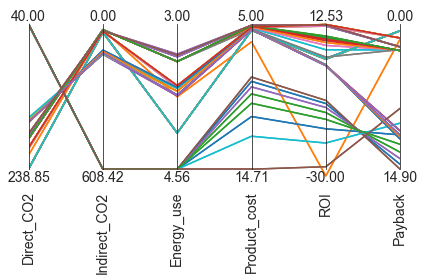

In [13]:
# Parallel axis plot - outcome tradeoffs. 
data = results_optimize_short.loc[:, [col.name for col in glass_model.outcomes]]  

limits = parcoords.get_limits(data)
limits.loc[0, ['Direct_CO2']] = 40
limits.loc[0, ['Indirect_CO2']]=0
limits.loc[0, ['Energy_use']]=3
limits.loc[0, ['Product_cost']]=5
limits.loc[0, ['ROI']]=-30
limits.loc[0, ['Payback']]= 0      
#limits.loc[0, ['Glass_Pull']]=2

# Reverse the axis for which the respective objective needs to be minimised
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis('Direct_CO2')         # minimize
paraxes.invert_axis('Indirect_CO2')       # minimize
paraxes.invert_axis('Energy_use')         # minimize  
paraxes.invert_axis('Product_cost')       # minimize
paraxes.invert_axis('Payback')            # minimize   

# Include a legend of policy names
colors = sns.color_palette(n_colors=results_optimize_short.shape[0])   

for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=[str(index), results_optimize_short.Technology[index]] , color=colors[i])  

#paraxes.legend()

plt.show()                  

<div class="alert alert-success">
<h1>3. Uncertainty Analysis</h1>

The assessment of the uncertainty of the output space given the uncertainty of the input space is generally referred to as uncertainty analysis (Pruyt, 2016). In this step, the MORDM uncertainty analysis interrogates each solution in the Pareto approximate set with a large number of alternative states of the world (SOWs) to see how the solution performs under a range of assumptions regarding the exogenous factors (Kasprzyk et al. 2013; Watson et al. 2017). At the end, we choose robust (constituent) solutions that have acceptable (Pareto satisficing) performance across a wide range of plausible future scenarios. It generally answers the question of *“Which of the uncertain input factors are more influential in determining the variability affecting the inference?”*, or *“If the uncertainty of one of the inputs could be eliminated, which one should be chosen in order to reduce to the minimum the variance of the output of interest?”* (Cariboni 2007).

Uncertainty analysis involves two steps. 
* Firstly, simulate outcomes for uncertainty ensemble. The sampling method named Latin Hypercube is used to build a large ensemble of vectors of the uncertainty parameters. Each ensemble member, or SOW, represents a set of values for each exogenous factor whose impact on future conditions is being explored.
* Secondly, a user-defined calculation of the deviation in performance between the baseline SOW and other SOW in the ensemble (Watson et al. 2017). The robustness of the alternatives is identified using a robustness metric (e.g. the Starr’s domain criterion) which **denotes a fraction of sampled scenarios** in which a solution achieves a threshold for each outcome of interest. 


### 3a. Create an uncertainty ensemble (using LHS) - Simulate outcomes for uncertainty ensemble.

This is accomplished through sampling across the uncertainty parameters identified in model specification. The XLRM specification is used to build a diverse ensemble of possible future states of the world (i.e. alternative scenarios), which span the uncertainty space specified in the first step. **We will figure out their robustness by determining the fraction of total scenarios for which a policy achieves the specific threshold for each outcome of interest.** Uncertainty analysis will be used here to construct alternative model instantiations and simulate these different model instantiations to generate a set of simulation runs that is representative for the entire multidimensional uncertainty space (Pruyt, 2016). See also insight in system and policy model and uncertainty analysis in Walker & Haasnoot (2011). 

The case can be simplified by setting a constraint of carbon emisisons on the results (i.e. the accepted solutions need to exceed a certan threshold). Based on the new solutions dataframe, a new list of policies is transformed into dictionaries and inputed to the *perform_experiments* function of the EMA workbench (i.e. input for the Policy class). 

In [14]:
policies = results_optimize_short
policies = policies.drop([col.name for col in glass_model.outcomes], axis=1)
policies

# For more than 1 seed
#policies = policies.drop([col.name for col in glass_model.outcomes], axis=1).drop("seed", axis=1)

,Technology,O2_substitution,Ratio_NG
4,9,21,91
6,5,41,76
13,7,56,91
17,7,45,93
23,5,12,77
25,7,38,89
26,2,26,80
29,5,32,79
32,4,20,79
33,7,20,96


In [15]:
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))
    
policies_to_evaluate

[Policy({'Technology': 9, 'O2_substitution': 21, 'Ratio_NG': 91}),
 Policy({'Technology': 5, 'O2_substitution': 41, 'Ratio_NG': 76}),
 Policy({'Technology': 7, 'O2_substitution': 56, 'Ratio_NG': 91}),
 Policy({'Technology': 7, 'O2_substitution': 45, 'Ratio_NG': 93}),
 Policy({'Technology': 5, 'O2_substitution': 12, 'Ratio_NG': 77}),
 Policy({'Technology': 7, 'O2_substitution': 38, 'Ratio_NG': 89}),
 Policy({'Technology': 2, 'O2_substitution': 26, 'Ratio_NG': 80}),
 Policy({'Technology': 5, 'O2_substitution': 32, 'Ratio_NG': 79}),
 Policy({'Technology': 4, 'O2_substitution': 20, 'Ratio_NG': 79}),
 Policy({'Technology': 7, 'O2_substitution': 20, 'Ratio_NG': 96}),
 Policy({'Technology': 2, 'O2_substitution': 52, 'Ratio_NG': 75}),
 Policy({'Technology': 6, 'O2_substitution': 22, 'Ratio_NG': 99}),
 Policy({'Technology': 9, 'O2_substitution': 30, 'Ratio_NG': 93}),
 Policy({'Technology': 4, 'O2_substitution': 31, 'Ratio_NG': 75}),
 Policy({'Technology': 5, 'O2_substitution': 23, 'Ratio_NG': 7

In [432]:
# Perform 1000 scenarios for each of the policy options. Given the number of solutions which are left after implementing 
# the constraint, multiprocessing evaluator is used to speed up calculations.

n_scenarios = 1000
with MultiprocessingEvaluator(glass_model) as evaluator:
    results_lhs = evaluator.perform_experiments(n_scenarios, policies_to_evaluate)  # uncertainty_sampling=LHS

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 46 policies * 1 model(s) = 46000 experiments
[MainProcess/INFO] 4600 cases completed
[MainProcess/INFO] 9200 cases completed
[MainProcess/INFO] 13800 cases completed
[MainProcess/INFO] 18400 cases completed
[MainProcess/INFO] 23000 cases completed
[MainProcess/INFO] 27600 cases completed
[MainProcess/INFO] 32200 cases completed
[MainProcess/INFO] 36800 cases completed
[MainProcess/INFO] 41400 cases completed
[MainProcess/INFO] 46000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [433]:
save_results(results_lhs, 'Uncertainty_analysis_glass_25e3.tar.gz')

[MainProcess/INFO] results saved successfully to C:\Users\LocalAdmin\Desktop\exper_8\Uncertainty_analysis_10e3Uni8_lowOxy_highBatch_3.tar.gz


In [434]:
# save the filtered policies
policies.to_csv('mordm filtered polices glass_25e3.csv')

In [16]:
results_lhs = load_results('Uncertainty_analysis_glass_25e3.tar.gz')

[MainProcess/INFO] results loaded succesfully from C:\Users\John\Desktop\New folder\Final\Uncertainty_analysis_glass_25e3.tar.gz


In [17]:
# By default, the return of perform_experiments is a tuple of length 2. 
# The first item in the tuple is the experiments, and the second one is the outcomes. 
# Experiments and outcomes are aligned by index. The experiments are stored in a numpy structured array, 
# while the outcomes are a dict with the name of the outcome as key, and the values are in a numpy array.

experiments_lhs, outcomes_lhs = results_lhs

In [18]:
# Plot the results using plotly pairplot
experiment_data=pd.DataFrame(experiments_lhs)
outcome_data = pd.DataFrame(outcomes_lhs)
results_df=pd.concat([experiment_data, outcome_data], axis=1)

In [21]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

parallel_plot_data = [
    go.Parcoords(
        line = dict(color = 'rgb(0, 176, 240)'
                   ),
        
        dimensions = list([
            dict(range = [0,250],
                 constraintrange = [0,200],
                 label = 'Direct emissions (kg CO2)', 
                 values = list(results_df['Direct_CO2'])),
            dict(range = [0,200],
                 constraintrange = [0,150],
                 label = 'Indirect emissions (kg CO2)', 
                 values = list(results_df['Indirect_CO2'])),
            dict(range = [2, 5],
                 constraintrange = [2.7, 3.6],
                 label = 'Energy use (GJ)', 
                 values = list(results_df['Energy_use'])),
            dict(range = [4, 10],
                 constraintrange = [5.5, 6.5],
                 label = 'Product cost (€-cent)', 
                 values = list(results_df['Product_cost'])),
            dict(range = [-100, 50],
                 constraintrange = [-10, 30],
                 label = 'ROI (%)', 
                 values = list(results_df['ROI']))
#            dict(range = [0, 20],
#                 constraintrange = [0, 15],
#                 label = 'Payback period (years)', 
#                 values = list(results_optimize_MORDM['Payback']))
        ])
    )
]

py.iplot(parallel_plot_data, filename = 'parcoord-dimensions')

### Feature scoring

Feature scoring helps identifying the most relevant features (i.e. uncertainties) to include in the model for each outcome of interest. It is often used at the early stage of the study just to get a sense which uncertainties do matter and which don't. It is also used in a validation kind of way. For example, if uncertainties show up that would expect to show more that don't, then we can go back to the model and see why this happens. We can focus either on the relation between uncertainties and outcomes, or levers with outcomes. Both of them are included in the heatmap below.

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


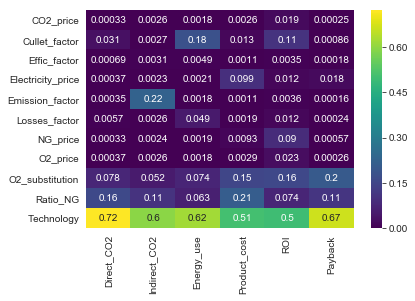

In [16]:
x = experiments_lhs.drop("policy", axis=1).drop("scenario", axis=1)  
y = outcomes_lhs

# Create a heatmap for depicting relations between objectives and uncertainties as well as levers.
fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap='viridis', annot=True)          
plt.show()

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


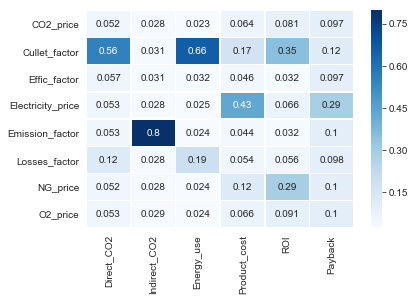

In [64]:
# Focus on relations with uncertainties only
# Defining the uncertainty space for feature scoring
x = experiments_lhs.drop("policy", axis=1).drop("scenario", axis=1).drop("O2_substitution", axis=1).\
                    drop("Ratio_NG", axis=1).drop("Technology", axis=1)

fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, annot=True, cmap='Blues', linewidths=0.5)
plt.show()

### 3b. Robustness calculation
A robustness metric takes as **input the performance of a candidate policy over a set of scenarios** (i.e. the previous scenario results) and returns a single robustness score. Therefroe, the robustness (i.e.  the performance) of each policy option will be identidied in terms of each outcome indicator (i.e. the performance of a policy option on an outcome indicator across 1000 scenarios). The metrics which will be leveraged are the Starr's domain criterion and the maximum regret. 

#### Starr's domain criterion - individual alternatives

The Starr's *Domain criterion* is used for quantifying robustness, and allows investigating the robustness tradeoffs for searching for compromise solutions. It's a metric that explores whether user-selected thresholds (i.e. constraints) are satisfied. Robustness values obtained with this metric could range from low to high, depending on the value of the user-selected minimum performance threshold (McPhail, 2017). 


In [19]:
# Retrieve the lowest 3 quartiles for all objectives for setting the boundaries. It ignores the best performing quartile.

Direct_optimize_constraint   = np.percentile(results_optimize_short['Direct_CO2'],75)
Indirect_optimize_constraint = np.percentile(results_optimize_short['Indirect_CO2'],75)
Energy_optimize_constraint   = np.percentile(results_optimize_short['Energy_use'],75)
Product_optimize_constraint  = np.percentile(results_optimize_short['Product_cost'],75)
ROI_optimize_constraint  = np.percentile(results_optimize_short['ROI'],75)
Payback_optimize_constraint  = np.percentile(results_optimize_short['Payback'],75)

In [20]:
# Starr's domain criterion

def robustness(direction, threshold, data):
    
    if direction == 'SMALLER':
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data>=threshold)/data.shape[0]

mordm_Direct_CO2         = functools.partial(robustness, 'SMALLER', Direct_optimize_constraint)  
mordm_Indirect_CO2       = functools.partial(robustness, 'SMALLER', Indirect_optimize_constraint)      
mordm_Energy_use         = functools.partial(robustness, 'SMALLER', Energy_optimize_constraint)  
mordm_Product_cost       = functools.partial(robustness, 'SMALLER', Product_optimize_constraint)
mordm_ROI                = functools.partial(robustness, 'LARGER',  ROI_optimize_constraint)
mordm_Payback            = functools.partial(robustness, 'SMALLER', Payback_optimize_constraint)

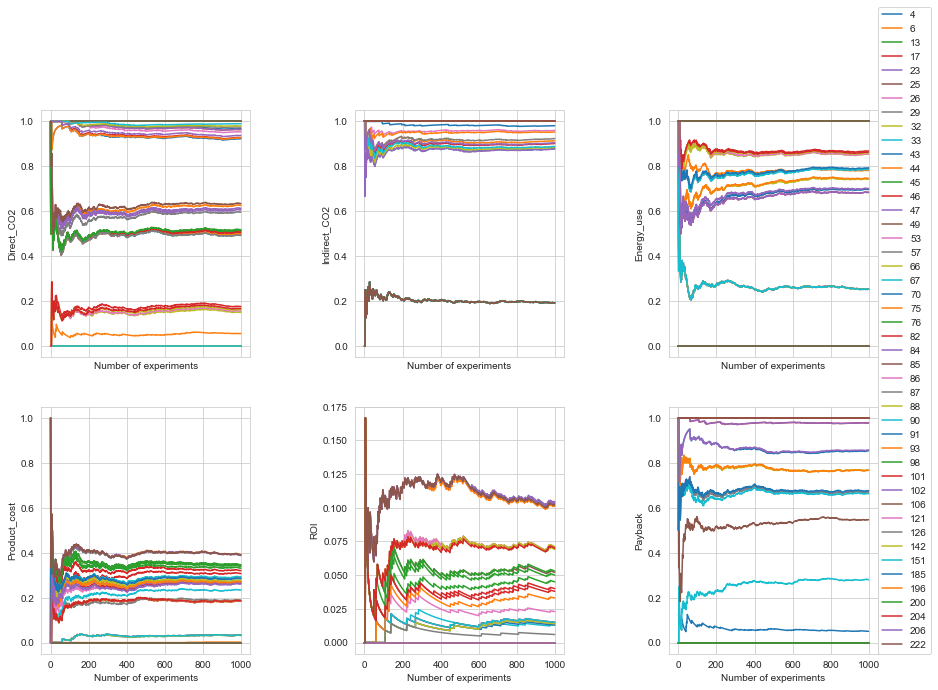

In [19]:
# Examine how the estimate of robustness converges to the true robustness value,
# as a function of the number of experiments used to calculate it. 

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15,10),
                        sharex=True)
axes = [axes[0,0],axes[0,1], axes[0,2],
        axes[1,0],axes[1,1], axes[1,2]]

robustness_funcs = {"Direct_CO2": mordm_Direct_CO2,
                    "Indirect_CO2": mordm_Indirect_CO2,
                    "Energy_use": mordm_Energy_use,
                    "Product_cost": mordm_Product_cost,
                    "ROI": mordm_ROI,
                    "Payback": mordm_Payback}

experiments_lhs, outcomes_lhs = results_lhs
#sns.set_palette(sns.color_palette("hls", results_optimize_short.shape[0])) 

for ax, (outcome, value) in zip(axes, outcomes_lhs.items()):
    for policy in np.unique(experiments_lhs['policy']):
        logical = experiments_lhs['policy'] == policy
        data = value[logical]
        
        robustness = []
        for i in range(1, data.shape[0]):
            robustness.append(robustness_funcs[outcome](data[0:i]))
        ax.plot(robustness, label=policy)
        plt.subplots_adjust(wspace = .5)
    ax.set_xlabel("Number of experiments")
    ax.set_ylabel(outcome)
    # Remove the top and left hand black outline of axes
    #sns.despine()

ax.legend(loc=[1, 0])
plt.show()        

In [21]:
# List of candidate policies
results_optimize_short

,Technology,O2_substitution,Ratio_NG,Direct_CO2,Indirect_CO2,Energy_use,Product_cost,ROI,Payback
4,9,21,91,40.00,608.42,4.56,8.82,-10.72,14.40
6,5,41,76,190.01,26.83,3.33,5.06,12.36,2.32
13,7,56,91,196.60,22.94,3.40,5.12,8.52,2.70
17,7,45,93,196.82,22.45,3.40,5.15,7.78,2.68
23,5,12,77,190.16,26.48,3.32,5.06,12.37,2.32
25,7,38,89,196.37,23.46,3.40,5.11,8.96,2.70
26,2,26,80,238.85,31.94,4.17,5.40,2.49,0.66
29,5,32,79,191.89,26.01,3.35,5.06,12.04,2.31
32,4,20,79,210.98,28.59,3.68,5.20,12.00,1.40
33,7,20,96,197.12,21.75,3.40,5.24,5.08,2.63


#### Maximum regret - comparing alternatives

*Maximum regret* is calculated for each policy and for each outcome indicator. *Regret* is defined for each policy under each scenario, as the difference between the performance of the policy in a specific scenario and the performance of a no-regret (i.e. best possible result in that scenario, which is the lowest in case of mimimization, and heighest in case of maximization) or reference policy. The *maximum regret*  is then the maximum of such regret values across all scenarios. Policy options with low *maximum regret* values are the most preferable. 

In [22]:
# Maximum regret
# Find the best possible outcome for each scenario

overall_regret = {}
max_regret = {}

experiments_lhs, outcomes_lhs = results_lhs

for outcome in glass_model.outcomes:
    policy_column = experiments_lhs['policy']
    
    # Create a dataFrame with all relevant information 
    data = pd.DataFrame({outcome.name: outcomes_lhs[outcome.name], 
                         "policy":experiments_lhs['policy'],
                         "scenario":experiments_lhs['scenario']})
    
    # Reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')
    
    # Flatten the resulting hierarchical index resulting from pivoting
    data.columns = data.columns.get_level_values(1)
    
    # Ensure that the shape is the same as the data by using np.newaxis
    # Then take the difference of the maximum across the row and the actual values in the row.
    # Take the absolute value of the difference to avoid negative regret values when mimimiz]sing.
    
    outcome_regret = (data.max(axis=1)[:, np.newaxis] - data).abs()
    
    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

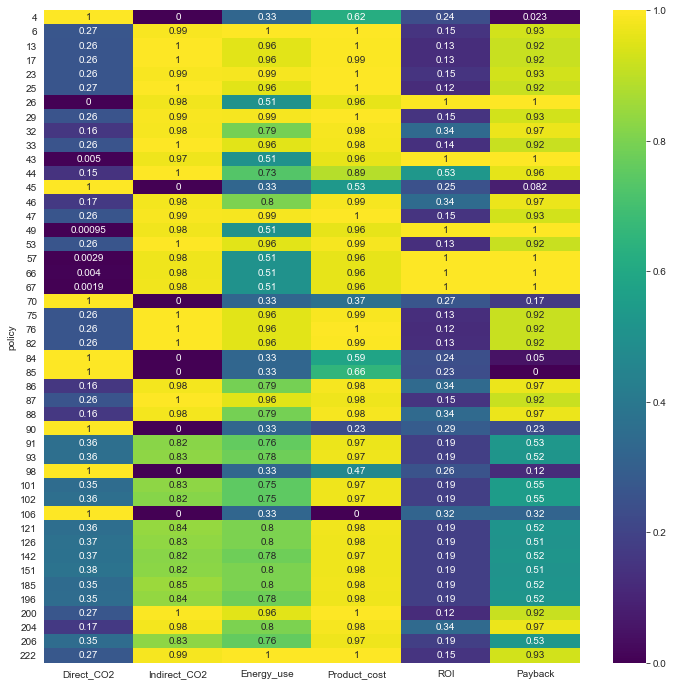

In [24]:
max_regret = pd.DataFrame(max_regret)
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)   #linewidths=0.05
plt.show()

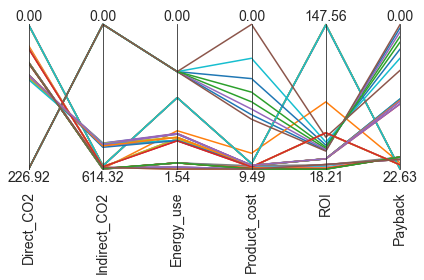

In [25]:
data = max_regret

#data['Policy ID'] = data.index.astype("float64")  

limits = parcoords.get_limits(data)
limits.loc[0, ['Direct_CO2', 'Indirect_CO2', 'Energy_use', 'Product_cost', 'Payback']] = 0

paraxes = parcoords.ParallelAxes(limits)
  
paraxes.invert_axis('Direct_CO2')         # minimize
paraxes.invert_axis('Indirect_CO2')       # minimize
paraxes.invert_axis('Energy_use')         # minimize  
paraxes.invert_axis('Product_cost')       # minimize
paraxes.invert_axis('Payback')            # minimize

# Include a legend of policy names
colors = sns.color_palette(n_colors=data.shape[0])
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i]) 
    
#paraxes.legend()
plt.show()

<div class="alert alert-success">
<h1>4. Scenario Discovery</h1>

The Patient Rule Induction Method (PRIM) is used for rule induction in Scenario discovery. The identification of influential factors allows the iterative improvement of the model with inclusion of decision levers of the previous steps. That way, we 
develop easy to understand descriptions of which areas of the uncertainty space remain vulnerable, despite searching for alternatives that are meant to be the most successful. The goal is to **find combinations of uncertain variables that best predict a particular outcome which are defined in terms of performance measure thresholds**. As a result, *we examine tradeoffs with solutions that reduce vulnerabilities*.
* First, we set thresholds for each of the performance measures (i.e. model outcomes). Uncertainty ensemble members that violate these thresholds are hereafter termed “vulnerable”.
* Use PRIM to identify points with vulnerable performance by “peeling” away thin layers of the uncertainty space to identify scenarios and also iteratively increases or decreases dimensions of the proposed candidate box. Each scenario represents ranges of exogenous parameter values over which the candidate solution performs poorly. Such scenarios are the same as before, since they provide simple descriptions of future trajectories.
* Repreat process, by picking one of the alternative candidate boxes that PRIM suggests; the boxes lie on a Pareto optimal surface. 

Density indicates how many of the captured points within a scenario are actually in the vulnerable set. 
Interpretability indicates how easily users can understand the information, and is considered to decrease with the number of parameters used to define the box. Qp denotes the uncertain parameters which are less important in describing the vulnerable cases.

#### 4a. Dimensional stacking

This method is complementary to Scenario discovery, since it generally produces the same results. Often used as a diagnostic prior to Scenario discovery, because it's often easier to see if I am going to need multible boxes from a dimensional stacking plot. It also indictes if more scenarios have to be performed by looking at possible white spaces.  It can either have uncertainties or policies on the vertical axis. 

This technique involves the identification of the most important uncertainties that affect system behavior by using the classification of identified outcomes. Moreover, a pivot table is created using the most influential uncertainties. Its creation involves binning the continuous uncertainties for discretizing them. The visualisation of results can be refined by adjusting the number of bins or layers.

In [26]:
results_lhs = load_results('Uncertainty_analysis_glass_25e3.tar.gz')
experiments_lhs, outcomes_lhs = results_lhs

[MainProcess/INFO] results loaded succesfully from C:\Users\John\Desktop\New folder\Final\Uncertainty_analysis_glass_25e3.tar.gz


[MainProcess/INFO] model dropped from analysis because only a single category


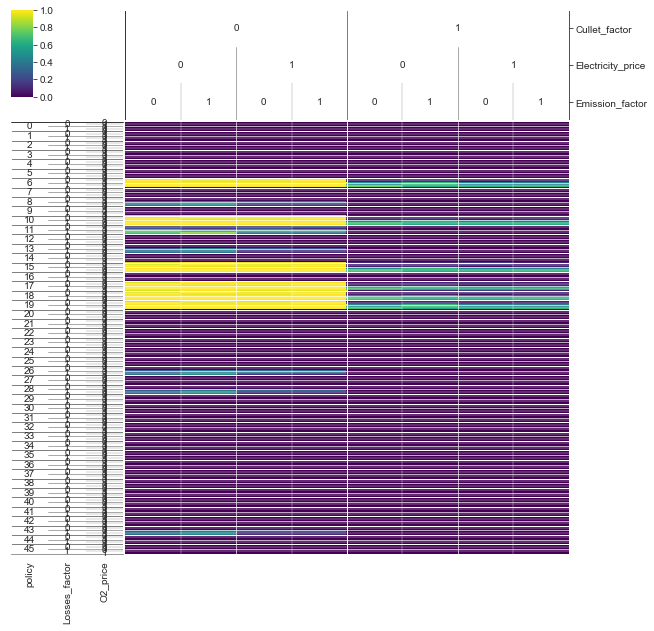

In [147]:
x = experiments_lhs.drop([col.name for col in glass_model.levers], axis=1)

# Try removing other uncertainties and observe the changes in the figure below. 
x.drop('Effic_factor', axis=1, inplace=True)
x.drop('CO2_price', axis=1, inplace=True)

y = outcomes_lhs['Direct_CO2']> np.percentile(outcomes_lhs['Direct_CO2'], 90) 

# Adjust the number of bins for better clarity
dimensional_stacking.create_pivot_plot(x,y, 3, nbins=2)
plt.show()

#### 4b. Scenario discovery

The binary classification should results in a max 20% of cases of interest. Use PRIM to see the amount of cases of interest in a certain box. These cases of interest have the largest extent of bad performing scenarios on Direct CO2. The peeling alpha determines the percentile of data which is peeled off in each iteration of the algorithm (i.e. controls the leniency of the algorithm). The lower the value, the less data is removed in each iteration (i.e. the lower the more lenient).

In [27]:
# "X" contains the experimental design (independent variables, numpy structured array)
# "Y" contains the classification (dependent variable, 1d numpy array)

# Retrieve the results from the uncertainty analysis
results_lhs = load_results('Uncertainty_analysis_glass_25e3.tar.gz')
experiments_lhs, outcomes_lhs = results_lhs

# Remove the columns of levers, because they implicate with the results.
experiments_lhs_drop = experiments_lhs.drop([col.name for col in glass_model.levers], axis=1)
experiments_lhs_drop = experiments_lhs_drop.drop("policy", axis=1) 

x_sd = experiments_lhs_drop
y_sd = outcomes_lhs['Direct_CO2'] > np.percentile( outcomes_lhs['Direct_CO2'], 80) 

z_sd = [0 for i in range(len(y_sd))]
for i in range(len(y_sd)):
    if y_sd[i]:
        z_sd[i]=1
z_sd = np.array(z_sd)

[MainProcess/INFO] results loaded succesfully from C:\Users\John\Desktop\New folder\Final\Uncertainty_analysis_glass_25e3.tar.gz


In [28]:
# PRIM_1
prim_alg = prim.Prim(x_sd, z_sd, threshold=0.3, peel_alpha=0.05) #try also alpha 0.01 

[MainProcess/INFO] model dropped from analysis because only a single category


[MainProcess/INFO] 46000 points remaining, containing 9200 cases of interest
[MainProcess/INFO] mean: 0.5281329923273658, mass: 0.051, coverage: 0.13467391304347825, density: 0.5281329923273658 restricted_dimensions: 5


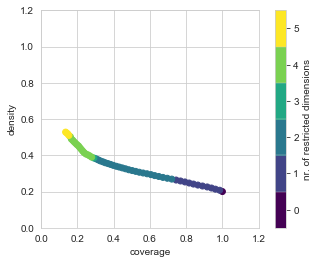

In [158]:
# Use the instantiated algorithm and find a first box.
box1 = prim_alg.find_box()  # We expect to find a first box that explains close to 80% of the cases of interest. 

# These cases of interest have the largest extent of bad performing scenarios on product price.
# Show the trade off curve and examine the trade offs between coverage and density.
box1.show_tradeoff()

#sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
plt.show()

coverage    0.134674
density     0.528133
id                55
mass           0.051
mean        0.528133
res_dim            5
Name: 55, dtype: object

                  box 55                                           
                     min        max                       qp values
Cullet_factor   0.800254   0.855881  [-1.0, 3.685327508973068e-183]
Effic_factor    0.950047   1.041998      [-1.0, 0.2023506524534734]
CO2_price      18.000000  58.500000      [-1.0, 0.5084034049744783]
Losses_factor   1.028146   1.049966   [9.551651087514515e-38, -1.0]
NG_price        0.039103   0.059995     [0.32889937751542214, -1.0]



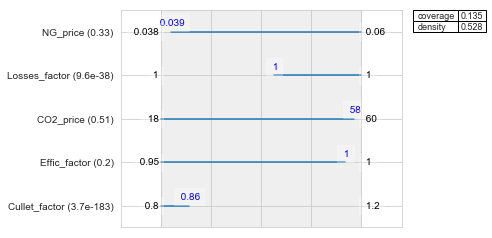

In [161]:
# Investigate the box that PRIM produced by inspecting a point on the trade off curve. 
# Select a point of this box which is close to a dimension change that also compromises low coverage for high density. 

box1.inspect(55)    
box1.inspect(55, style='graph') 

plt.show()         # Also show the results in a table format

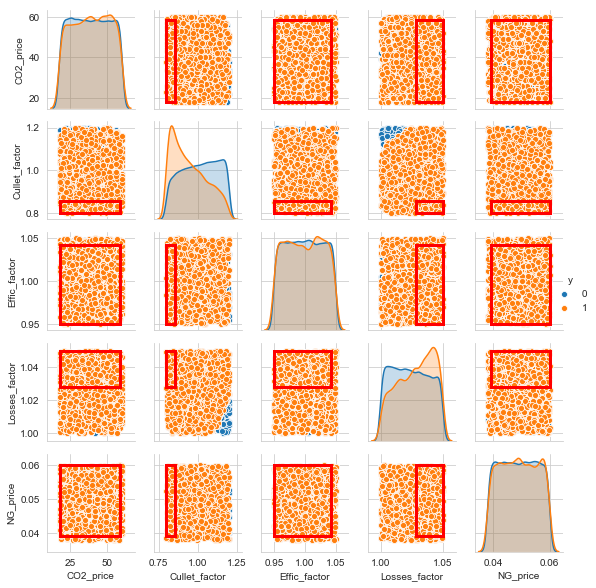

In [135]:
# Show the results in a visual format
box1.select(55)           
box1.show_pairs_scatter()  
fig = plt.gcf()
fig.set_size_inches(8,8)
plt.show()

[MainProcess/INFO] 43654 points remaining, containing 7961 cases of interest
[MainProcess/INFO] mean: 0.34484228473998296, mass: 0.051, coverage: 0.08793478260869565, density: 0.34484228473998296 restricted_dimensions: 7


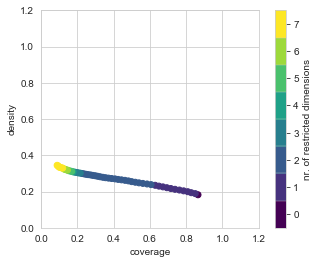

In [140]:
# Examine if a second box exists that explains the remainder of the cases.
box2 = prim_alg.find_box()

# The logging will inform us whether an additional box can be found. 
# It depends on the minimium density threshold that a box should meet, which has been set in the analysis above.

# Examine the trade off between coverage and density.

box2.show_tradeoff()
plt.show()

coverage    0.0879348
density      0.344842
id                 54
mass            0.051
mean         0.344842
res_dim             7
Name: 54, dtype: object

                      box 54             \
                         min        max   
Cullet_factor       0.800254   0.887257   
CO2_price          18.000000  59.500000   
Losses_factor       1.014630   1.049966   
Emission_factor     0.024934   0.499886   
NG_price            0.038540   0.059995   
O2_price            0.052137   0.092860   
Electricity_price   0.031426   0.067578   

                                                              
                                                   qp values  
Cullet_factor                 [-1.0, 2.4843809879696256e-58]  
CO2_price                        [-1.0, 0.32384351906264436]  
Losses_factor                 [2.9779601919944813e-05, -1.0]  
Emission_factor                  [0.32384351906264436, -1.0]  
NG_price                         [0.32384351906264436, -1.0]  
O2_price      

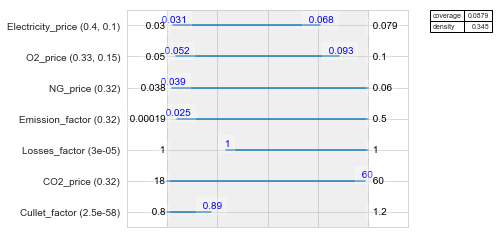

In [163]:
box2.inspect(54)
box2.inspect(54, style='graph') 
plt.show()

In [147]:
box3 = prim_alg.find_box()

[MainProcess/INFO] 41308 points remaining, containing 7152 cases of interest
[MainProcess/INFO] box does not meet threshold criteria, value is 0.289002557544757, returning dump box


In [148]:
# Look at the final overal results from interactively fitting PRIM to the data. 
# For this, we can use to convenience functions that transform the stats and boxes to pandas data frames.

print (prim_alg.stats_to_dataframe())
print (prim_alg.boxes_to_dataframe())

       coverage   density   mass  res_dim
box 1  0.134674  0.528133  0.051        5
box 2  0.087935  0.344842  0.051        7
box 3  0.777391  0.173138  0.898        0
                       box 1                 box 2                 box 3  \
                         min        max        min        max        min   
Cullet_factor       0.800254   0.855881   0.800254   0.887257   0.800254   
Losses_factor       1.028146   1.049966   1.014630   1.049966   1.000048   
Effic_factor        0.950047   1.041998   0.950047   1.049922   0.950047   
NG_price            0.039103   0.059995   0.038540   0.059995   0.038002   
CO2_price          18.000000  58.500000  18.000000  59.500000  18.000000   
Electricity_price   0.030024   0.079277   0.031426   0.067578   0.030024   
O2_price            0.050031   0.099959   0.052137   0.092860   0.050031   
Emission_factor     0.000194   0.499886   0.024934   0.499886   0.000194   

                              
                         max  
Cullet_fa

<div class="alert alert-success">
<h1>5. Additional Visualisation</h1>

In [22]:
# Focus on the best performing policies in terms of Direct CO2 emissions

new_outcomes=pd.DataFrame(outcomes_lhs)
new_experiments=pd.DataFrame(experiments_lhs)

new_experiments.drop(new_experiments[new_outcomes["Direct_CO2"]>180].index, inplace=True)
new_experiments.reset_index(inplace=True, drop=True)

new_outcomes.drop(new_outcomes[new_outcomes["Direct_CO2"]>180].index, inplace=True)
new_outcomes.reset_index(inplace=True, drop=True)

new_outcomes.shape
#new_experiments.shape

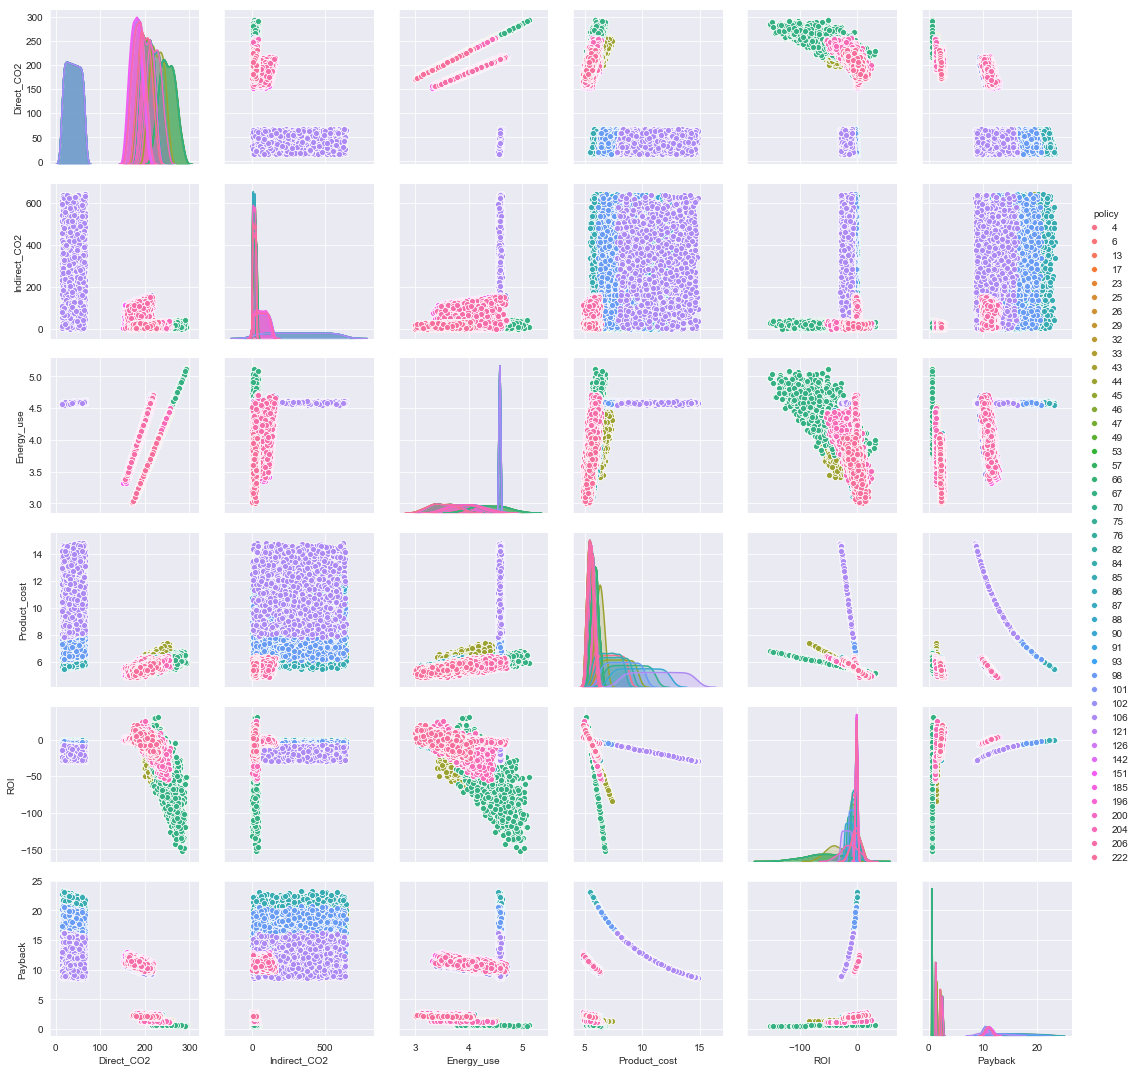

In [23]:
df = new_outcomes
df = df.assign(policy=new_experiments['policy'])  

# use seaborn to plot the dataframe
grid = sns.pairplot(df, hue='policy', vars=new_outcomes.keys())  # or: list(outcomes.keys())
ax = plt.gca()
plt.show();

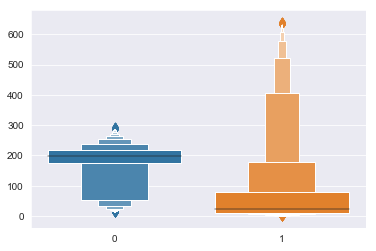

In [24]:
ax = sns.boxenplot(data=[df.Direct_CO2, df.Indirect_CO2])
# requires normalisation in a scale of 0-1 to make sensible use of all performance metrics in one graph.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

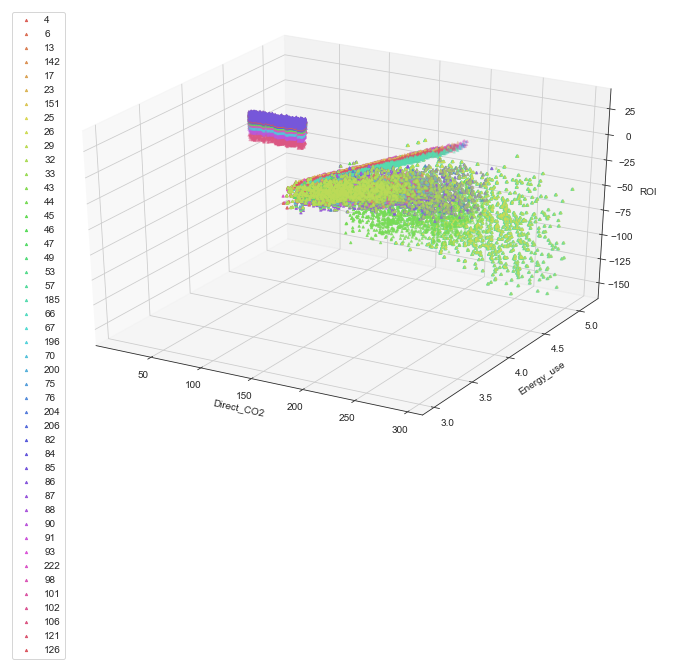

In [40]:
# Import the plotting tools to create a 3d stacking plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sns.set_palette(sns.color_palette("hls", results_optimize_short.shape[0]))  

colors = sns.color_palette(n_colors=results_optimize_short.shape[0])
markers = ['^']
oois = ['Direct_CO2', 'Energy_use','ROI']

#setting the axis of the 3d plot with the aformentioned performance indicators/objectives
ax.set_xlabel(oois[0])
ax.set_ylabel(oois[1])
ax.set_zlabel(oois[2])

# Perform iterations over the assessed combinations of policy levers in the experiments
for p, policy in enumerate(set(experiments_lhs['policy'])):
    
    #selecting based on policy to form grouping in the plot
    logical = experiments_lhs['policy']==policy
    outcomes_3D = {key:value[logical] for key, value in outcomes_lhs.items()}
    experiments_3D = experiments_lhs[logical]
    
    x = outcomes_3D[oois[0]]
    y = outcomes_3D[oois[1]]
    z = outcomes_3D[oois[2]]
    
    ax.scatter(x, y, z, c=colors[p], marker=markers[0], s=5, label=policy)

ax.legend(loc=2, scatterpoints = 1)

fig.set_figheight(8)
fig.set_figwidth(12)

plt.show()

<div class="alert alert-success">
<h1> 6. Second MORDM iteration</h1>

The Model Specification is re-visited in order to incorporate the observations and the lessons leaned from the 1st MORDM iteration into the analysis. The performed adjustments are indicated in comments. This will lead to the generation of a second Pareto approximate set with the inclusion of options that use alternatve fuels (i.e. biomethane). Straight comparisons will be performed between the two pareto sets in terms of the selected performance metrics.

In [29]:
# Define system model
glass_model = ExcelModel("excelmodel", wd="./Model", model_file='Glass_MORDM.xlsx')

# Locate the Excel sheet
glass_model.default_sheet = "Global"

# Specification of uncertainties
glass_model.uncertainties = [RealParameter('NG_price', 0.038, 0.06),
                       RealParameter('Electricity_price', 0.03, 0.0793),
                       IntegerParameter('CO2_price', 18, 60),
                       RealParameter('O2_price', 0.05, 0.1), 
                       RealParameter('Bio_price', 0.5, 0.9),         # 2ND: ADDED
                       RealParameter('Emission_factor', 0, 0.5),   
                       RealParameter('Losses_factor', 1, 1.05),    
                       #RealParameter('Effic_factor', 0.95, 1.05),
                       RealParameter('Cullet_factor', 0.8, 1.25)     # 2ND: CHANGED FROM 1.2       
                       ]

# Specification of levers
glass_model.levers = [IntegerParameter('Technology', 0, 9),
                  IntegerParameter('O2_substitution', 0, 60),
                  IntegerParameter('Ratio_NG', 75, 99),
                  #IntegerParameter('Glass_type', 1, 3),        
                  IntegerParameter('Bio_switch', 0, 1)               # 2ND: ADDED
                  ]     
                                                                   
# Specification of outcomes
glass_model.outcomes = [ScalarOutcome("Direct_CO2", kind=ScalarOutcome.MINIMIZE),
                  ScalarOutcome("Indirect_CO2", kind=ScalarOutcome.MINIMIZE),
                  ScalarOutcome("Energy_use", kind=ScalarOutcome.MINIMIZE),
                  #ScalarOutcome("Glass_Pull", kind=ScalarOutcome.MAXIMIZE),
                  ScalarOutcome("Product_cost", kind=ScalarOutcome.MINIMIZE),
                  ScalarOutcome("ROI", kind=ScalarOutcome.MAXIMIZE)
                  #ScalarOutcome("Payback", kind=ScalarOutcome.MINIMIZE)           # 2ND: REMOVED
                  ]

In [ ]:
# Set a reference scenario
reference = Scenario('reference', Electricity_price=0.0793, NG_price=0.038, 
                     CO2_price=25, O2_price=0.06, Cullet_factor=1, 
                     Emission_factor=0.48, Losses_factor=1, Bio_price = 0.8)       # 2ND: no Effic_factor,  added bio_price

# Track convergence
convergence_value = [EpsilonProgress(), HyperVolume(minimum=[0,0,0,0,0],           # 2ND: DECREASED HYPERVOLUME
                     maximum=[10, 10, 2.5, 4.5, 50])]                                                

# Search over levers
with MultiprocessingEvaluator(glass_model) as evaluator:
 
        results, convergence = evaluator.optimize(nfe=25000, searchover='levers',
                                     epsilons=[0.01,]*len(glass_model.outcomes),
                                     convergence=convergence_value,
                                     reference=reference)     

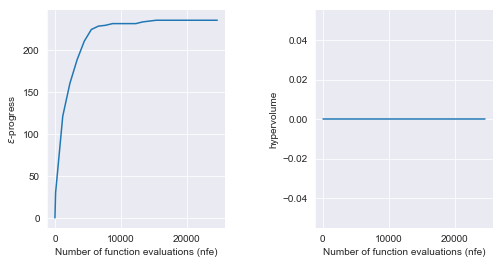

In [12]:
# Track convergence

fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4)) 
ax1.plot(convergence.nfe, convergence.epsilon_progress)               
ax1.set_ylabel('$\epsilon$-progress')                                 
ax2.plot(convergence.nfe, convergence.hypervolume)                    
ax2.set_ylabel('hypervolume')                                         

ax1.set_xlabel('Number of function evaluations (nfe)')
ax2.set_xlabel('Number of function evaluations (nfe)')

# Remove the top and left hand black outline of axes
sns.despine()

plt.subplots_adjust(wspace = .5)
plt.show()  

In [13]:
results.to_csv("Container_glass_25e3_2nd.csv")

In [30]:
# Show the most promising solutions, as extracted from the optimization above.

results_optimize_MORDM_bio = pd.read_csv('Container_glass_25e3_2nd.csv')
results_optimize_MORDM_bio.drop(results_optimize_MORDM_bio.iloc[:, [0]], axis=1, inplace=True)
results_optimize_MORDM_bio=round(results_optimize_MORDM_bio, 2)
#results_optimize_MORDM_bio.drop([39], inplace=True)
#results_optimize_MORDM_bio.reset_index(inplace=True, drop=True)
results_optimize_MORDM_bio

,Technology,O2_substitution,Ratio_NG,Bio_switch,Direct_CO2,Indirect_CO2,Energy_use,Product_cost,ROI
0,9,24,75,1,40.00,608.42,4.56,6.94,-4.79
1,7,19,92,1,175.74,21.13,3.17,6.02,-17.46
2,7,44,81,1,174.53,24.00,3.17,5.99,-16.48
3,5,60,80,1,172.28,24.01,3.13,5.96,-18.50
4,5,60,75,1,171.60,25.61,3.13,5.97,-18.72
5,7,30,89,1,175.44,21.84,3.17,6.00,-16.82
6,7,36,88,1,175.34,22.09,3.17,5.99,-16.71
7,5,13,78,1,172.02,24.62,3.13,5.96,-18.56
8,7,15,98,0,197.32,21.30,3.40,5.47,-1.42
9,5,44,76,0,190.01,26.83,3.33,5.06,12.36


In [31]:
results_optimize_MORDM_bio['Technology'].value_counts()

1    61
7    37
5    28
4     3
9     1
Name: Technology, dtype: int64

In [44]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

parallel_plot_data = [
    go.Parcoords(
        line = dict(color = 'rgb(0, 176, 240)'
                   ),
        
        dimensions = list([
            dict(range = [0,240],
                 constraintrange = [0,202],
                 label = 'Direct emissions (kg CO2)', 
                 values = list(results_optimize_MORDM_bio['Direct_CO2'])),
            dict(range = [0,150],
                 constraintrange = [0,120],
                 label = 'Indirect emissions (kg CO2)', 
                 values = list(results_optimize_MORDM_bio['Indirect_CO2'])),
            dict(range = [2, 5],
                 constraintrange = [3, 4],
                 label = 'Energy use (GJ)', 
                 values = list(results_optimize_MORDM_bio['Energy_use'])),
            dict(range = [3, 7],
                 constraintrange = [5, 6.3],
                 label = 'Product cost (€-cent)', 
                 values = list(results_optimize_MORDM_bio['Product_cost'])),
            dict(range = [-20, 50],
                 constraintrange = [-20, 20],
                 label = 'ROI (%)', 
                 values = list(results_optimize_MORDM_bio['ROI']))
        ])
    )
]

py.iplot(parallel_plot_data, filename = 'parcoord-dimensions')

In [32]:
# Cases of Technology 1 that I am not interested in (i.e. regenerative furnace with batch preheater).
results_optimize_MORDM_bio.drop(results_optimize_MORDM_bio[(results_optimize_MORDM_bio.Technology==1) &\
                                                   (results_optimize_MORDM_bio.Energy_use>=3.8) ].index, inplace = True)

results_optimize_MORDM_bio.drop(results_optimize_MORDM_bio[(results_optimize_MORDM_bio.Technology==1) &\
                                                   (results_optimize_MORDM_bio.Direct_CO2>=175) ].index, inplace = True)

results_optimize_MORDM_bio.drop(results_optimize_MORDM_bio[(results_optimize_MORDM_bio.Technology==1)&\
                                                   (results_optimize_MORDM_bio.Bio_switch==0) ].index, inplace = True)

# Cases of Technology 2 that I am not interested in (i.e. oxyfuel furnace)
results_optimize_MORDM_bio.drop(results_optimize_MORDM_bio[(results_optimize_MORDM_bio.Technology==2) &\
                                                   (results_optimize_MORDM_bio.Direct_CO2>=239) ].index, inplace = True)

# Cases of Technologies 4 and 5 that I am not interested in.
results_optimize_MORDM_bio.drop(results_optimize_MORDM_bio[
    ((results_optimize_MORDM_bio.Technology==4)|(results_optimize_MORDM_bio.Technology==5) ) &\
    (results_optimize_MORDM_bio.ROI<10) ].index, inplace = True)

results_optimize_MORDM_bio.drop(results_optimize_MORDM_bio[(results_optimize_MORDM_bio.Technology==4) &\
                                                   (results_optimize_MORDM_bio.Direct_CO2>=211) ].index, inplace = True)

results_optimize_MORDM_bio.drop(results_optimize_MORDM_bio[(results_optimize_MORDM_bio.Technology==5) &\
                                                   (results_optimize_MORDM_bio.Direct_CO2>=192) ].index, inplace = True)

# Cases of Technology 7 that I am not interested in.
results_optimize_MORDM_bio.drop(results_optimize_MORDM_bio[(results_optimize_MORDM_bio.Technology==7) &\
                                                   (results_optimize_MORDM_bio.ROI<0) ].index, inplace = True)

In [33]:
results_optimize_short_bio = results_optimize_MORDM_bio[ 
                        (results_optimize_MORDM_bio.Direct_CO2<250)  ]

results_optimize_short_bio.Technology.value_counts()

1    12
7    10
5     5
4     3
9     1
Name: Technology, dtype: int64

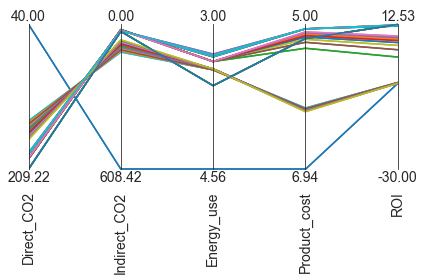

In [34]:
# Parallel axis plot - outcome tradeoffs. 
data = results_optimize_short_bio.loc[:, [col.name for col in glass_model.outcomes]]  

# Add an extra column in the pairplot for identifying the number of the policy (i.e. handy way for enumeration)
#data['"Policy ID"'] = data.index.astype("float64")        

limits = parcoords.get_limits(data)
limits.loc[0, ['Direct_CO2']] = 40
limits.loc[0, ['Indirect_CO2']]=0
limits.loc[0, ['Energy_use']]=3
limits.loc[0, ['Product_cost']]=5
limits.loc[0, ['ROI']]=-30
#limits.loc[0, ['Glass_Pull']]=2

# Reverse the axis for which the respective objective needs to be minimised
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis('Direct_CO2')         # minimize
paraxes.invert_axis('Indirect_CO2')       # minimize
paraxes.invert_axis('Energy_use')         # minimize  
paraxes.invert_axis('Product_cost')       # minimize

# Include a legend of policy names
colors = sns.color_palette(n_colors=results_optimize_short_bio.shape[0])     

for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=[str(index), results_optimize_short_bio.Technology[index]] , color=colors[i])  

#paraxes.legend()

plt.show()                  

<div class="alert alert-success">
<h1> 7. Comparison of Pareto approximate sets</h1>


In [5]:
results_optimize_MORDM_1st = pd.read_csv('Container_glass_25e3.csv')
results_optimize_MORDM_2nd = pd.read_csv('Container_glass_25e3_2nd.csv')

results_optimize_MORDM_1st.drop(results_optimize_MORDM_1st.iloc[:, [0]], axis=1, inplace=True)
#Drop Payback column, since this objective was removed rom the 2nd iteration
#results_optimize_MORDM_1st = results_optimize_MORDM_1st.drop("Payback", axis=1)

results_optimize_MORDM_2nd.drop(results_optimize_MORDM_2nd.iloc[:, [0]], axis=1, inplace=True)
#results_optimize_MORDM_1st = results_optimize_MORDM_1st[results_optimize_MORDM_1st.Direct_CO2 < 200]
results_optimize_MORDM_2nd = results_optimize_MORDM_2nd[results_optimize_MORDM_2nd.Direct_CO2 < 200]

results_optimize_MORDM_1st["BM"] = 0     
results_optimize_MORDM_2nd["BM"] = 1
results_optimize_MORDM_2nd=results_optimize_MORDM_2nd.drop("Bio_switch", axis=1)
results_optimize_MORDM_2nd.drop(results_optimize_MORDM_2nd[results_optimize_MORDM_2nd.Technology == 9].index, inplace=True)

results_optimize_MORDM_2nd.shape
results_optimize_MORDM_concat = pd.concat([results_optimize_MORDM_1st, results_optimize_MORDM_2nd], ignore_index=True)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [6]:
results_optimize_MORDM_concat = results_optimize_MORDM_concat.drop(results_optimize_MORDM_concat[results_optimize_MORDM_concat.ROI<-50].index)

In [7]:
results_optimize_MORDM_concat

,BM,Direct_CO2,Energy_use,Indirect_CO2,O2_substitution,Payback,Product_cost,ROI,Ratio_NG,Technology
0,0,192.571286,3.349397,24.455918,55,2.311688,5.068382,11.917207,84,5
1,0,198.296925,3.427857,22.366159,33,2.262187,5.179290,8.130836,94,5
2,0,40.000602,4.563113,608.415115,24,16.050076,7.916023,-7.866246,87,9
3,0,40.000602,4.563113,608.415115,38,15.332087,8.286724,-9.033322,89,9
4,0,40.000602,4.563113,608.415115,21,14.401460,8.822215,-10.719207,91,9
5,0,40.000602,4.563113,608.415115,13,18.197656,6.981821,-4.925098,76,9
6,0,190.007040,3.325075,26.833939,41,2.317559,5.055542,12.355547,76,5
7,0,240.270368,4.165471,28.705870,43,0.657469,5.420731,-0.367997,89,2
8,0,183.058294,3.908545,119.862032,0,2.752332,5.260481,4.336651,77,1
9,0,214.080898,3.711435,25.576930,31,1.387342,5.234158,10.096657,89,4


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.



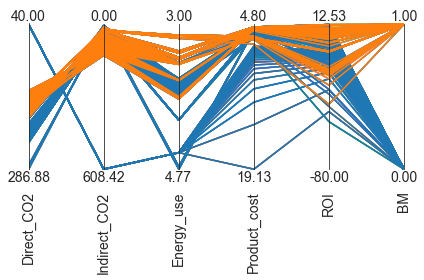

In [37]:
# Parallel axis plot - outcome tradeoffs. 
data = results_optimize_MORDM_concat.loc[:, [col.name for col in glass_model.outcomes]]  

data["BM"] = 0
data.tail(results_optimize_MORDM_concat.BM.value_counts()[1]).BM = 1   

limits = parcoords.get_limits(data)
limits.loc[0, ['Direct_CO2']] = 40
limits.loc[0, ['Indirect_CO2']]=0
limits.loc[0, ['Energy_use']]=3
limits.loc[0, ['Product_cost']]=4.8
limits.loc[0, ['ROI']]=-80
#limits.loc[0, ['Glass_Pull']]=2

# Reverse the axis for which the respective objective needs to be minimised
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis('Direct_CO2')         # minimize
paraxes.invert_axis('Indirect_CO2')       # minimize
paraxes.invert_axis('Energy_use')         # minimize  
paraxes.invert_axis('Product_cost')       # minimize


# Include a legend of policy names
colors = sns.color_palette(n_colors=results_optimize_MORDM_concat.shape[0])     

for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])  

paraxes.plot(data[data.BM == 0], color=colors[0])
paraxes.plot(data[data.BM == 1], color=colors[1])

#paraxes.legend()

plt.show()                  

In [38]:
# Comparisons betweeen two constrained sets

results_optimize_MORDM_1st = results_optimize_short
results_optimize_MORDM_2nd = results_optimize_short_bio

results_optimize_MORDM_1st["BM"] = 0     
results_optimize_MORDM_2nd["BM"] = 1
results_optimize_MORDM_1st = results_optimize_MORDM_1st.drop("Payback", axis=1)
results_optimize_MORDM_2nd=results_optimize_MORDM_2nd.drop("Bio_switch", axis=1)
#results_optimize_MORDM_2nd.drop(results_optimize_MORDM_2nd[results_optimize_MORDM_2nd.Technology == 9].index, inplace=True)

results_optimize_MORDM_2nd.shape
results_optimize_MORDM_concat = pd.concat([results_optimize_MORDM_1st, results_optimize_MORDM_2nd], ignore_index=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.



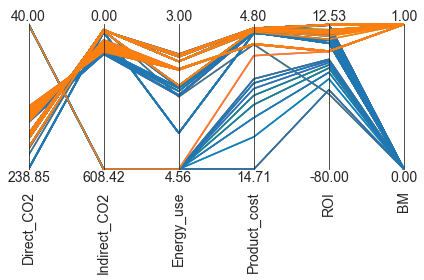

In [39]:
# Parallel axis plot - outcome tradeoffs. 
data = results_optimize_MORDM_concat.loc[:, [col.name for col in glass_model.outcomes]]  

data["BM"] = 0
data.tail(results_optimize_MORDM_concat.BM.value_counts()[1]).BM = 1   #INSTEAD OF 50, COUNT AND ADD HERE THE NUMBER OF ROWS WITH SEED = 1 IN THE ABOVE DF.

# Add an extra column in the pairplot for identifying the number of the policy (i.e. handy way for enumeration)
#data['"Policy ID"'] = data.index.astype("float64")        

limits = parcoords.get_limits(data)
limits.loc[0, ['Direct_CO2']] = 40
limits.loc[0, ['Indirect_CO2']]=0
limits.loc[0, ['Energy_use']]=3
limits.loc[0, ['Product_cost']]=4.8
limits.loc[0, ['ROI']]=-80

#limits.loc[0, ['Glass_Pull']]=2

# Reverse the axis for which the respective objective needs to be minimised
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis('Direct_CO2')         # minimize
paraxes.invert_axis('Indirect_CO2')       # minimize
paraxes.invert_axis('Energy_use')         # minimize  
paraxes.invert_axis('Product_cost')       # minimize


# Include a legend of policy names
colors = sns.color_palette(n_colors=results_optimize_MORDM_concat.shape[0])     # Also try color_palette("cubehelix", 8) or sns.hls_palette(8, l=.6, s=.6)

for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])  # or: label='Alternative {}'.format(i)

#paraxes.legend()

# For more than 1 seed
paraxes.plot(data[data.BM == 0], color=colors[0])
paraxes.plot(data[data.BM == 1], color=colors[1])

plt.show()                  

<div class="alert alert-success">
<h1> 8. Future work: Multiple seeds </h1>

A genetic algorithm uses random numbers to produce a set of sultions (i.e. perfomed in Policy determination step). This means that every single time we run the algorithm we get slighlty different results. It's a different concern than performing a second iteration of MORDM. Therefore it is a good practise to run the MOEA multiple times using a different random seed, hence take stochasticity into acccount and see if the results are similar or different. If they are similar, couple of seeds are enough. If they are different, it denotes a convergence problem of optimising. So seed analysis is necessary when appying evolutionary algorithms. We will perform least two seeds and compare those two result sets. If they are quite similar in terms of values/decision variables/objective values, then there is limited value in adding more seeds.

A search with multiple seeds was performed during the early stages of the research. It was decided to use only one seed, as the computational cost increased and the resulting solutions were quite similar to those from the 1st pareto set.

In [ ]:
# Track convergence
convergence_value = [HyperVolume(minimum=[0,0,0,0,0,0], maximum=[220, 150, 4.5, 6.5, 20, 2]), 
                       EpsilonProgress()]                                                

all_results = []
all_convergence = []

# Search over levers
with MultiprocessingEvaluator(glass_model) as evaluator:
    for rep in range(2): 
        results, convergence = evaluator.optimize(nfe=25000, searchover='levers',
                                     epsilons=[0.01,]*len(glass_model.outcomes),
                                     convergence=convergence_value)     # reference=reference
        results["seed"] = rep
        all_results.append(results)
        all_convergence.append(convergence)

In [99]:
# Show the most promising solutions, as extracted from the optimization above.

results_optimize_MORDM = pd.concat ([all_results[0], all_results[1]], ignore_index=True, axis=0)
results_optimize_MORDM=round(results_optimize_MORDM, 2)
results_optimize_MORDM.to_csv("Container_glass_1e3Uni6.csv")
results_optimize_MORDM = pd.read_csv('Container_glass_1e3Uni6.csv')
results_optimize_MORDM.drop(results_optimize_MORDM.iloc[:, [0]], axis=1, inplace=True)
#results_optimize_MORDM.drop([39], inplace=True)
#results_optimize_MORDM.reset_index(inplace=True, drop=True)
results_optimize_MORDM

C:\Users\LocalAdmin\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




,Bio_switch,Direct_CO2,Energy_requirement,Indirect_CO2,O2_substitution,Product_cost,ROI,Ratio_NG,Technology,seed
0,0,196.007116,3.404570,25.292348,41,5.071392,10.444360,86,NaN,0
1,0,191.741408,3.349892,27.438576,38,5.041029,7.850916,78,NaN,0
2,1,136.082388,2.163899,12.021661,79,5.289902,0.722782,96,NaN,0
3,0,196.707884,3.404196,23.640249,49,5.110362,9.268218,92,NaN,0
4,0,195.201233,3.405004,27.192737,46,5.063058,10.695892,80,NaN,0
5,0,190.007040,3.325075,27.952020,33,5.031918,8.040952,76,NaN,0
6,0,196.921593,3.404082,23.136493,9,5.145276,8.214482,94,NaN,0
7,0,192.571286,3.349397,25.474915,34,5.044763,7.773034,84,NaN,0
8,0,194.905054,3.405164,27.891300,72,5.063006,10.697456,78,NaN,0
9,0,197.225634,3.403921,22.419871,46,5.292624,3.767426,97,NaN,0


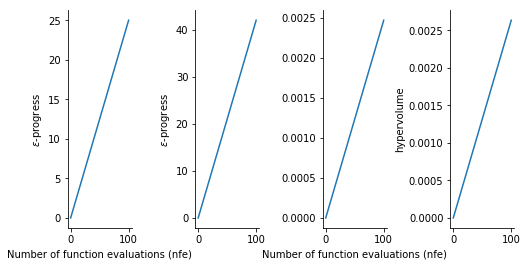

In [9]:
# Plot the ϵ-progress to evaluate convergence, and visualize the trade-offs using parallel coordinate plots.

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, sharex=True, figsize=(8,4))   
ax1.plot(all_convergence[0].nfe, all_convergence[0].epsilon_progress)               
ax1.set_ylabel('$\epsilon$-progress')                                 
ax2.plot(all_convergence[1].nfe, all_convergence[1].epsilon_progress)               
ax2.set_ylabel('$\epsilon$-progress')                                 

ax3.plot(all_convergence[0].nfe, all_convergence[0].hypervolume)                    
ax4.set_ylabel('hypervolume')                                         
ax4.plot(all_convergence[1].nfe, all_convergence[1].hypervolume)                    
ax4.set_ylabel('hypervolume')                                         

ax1.set_xlabel('Number of function evaluations (nfe)')
ax3.set_xlabel('Number of function evaluations (nfe)')


# Remove the top and left hand black outline of axes
sns.despine()

plt.subplots_adjust(wspace = 1)
plt.show()  

# if a graph flattens close to the end (i.e. it becomes stable), seems like we have convergence. 
# Otherwise, run the optimization even longer. Establising the number of NFE is generally a form of trial and error. 
# Same for the limits for Hypervolume.

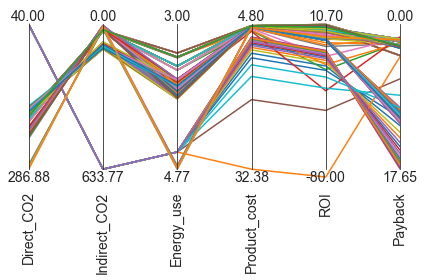

In [123]:
# Comparison of seeds

results_optimize_MORDM["seed"] = 0     
results_optimize_MORDM.tail(50).seed = 1

# Parallel axis plot - outcome tradeoffs. 
data = results_optimize_MORDM.loc[:, [col.name for col in glass_model.outcomes]]  

data["seed"] = 0
data.tail(results_optimize_MORDM.seed.value_counts()[1]).seed = 1  

limits = parcoords.get_limits(data)
limits.loc[0, ['Direct_CO2']] = 40
limits.loc[0, ['Indirect_CO2']]=0
limits.loc[0, ['Energy_use']]=3
limits.loc[0, ['Product_cost']]=4.8
limits.loc[0, ['ROI']]=-80
limits.loc[0, ['Payback']]= 0

# Reverse the axis for which the respective objective needs to be minimised
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis('Direct_CO2')         # minimize
paraxes.invert_axis('Indirect_CO2')       # minimize
paraxes.invert_axis('Energy_use')         # minimize  
paraxes.invert_axis('Product_cost')       # minimize
paraxes.invert_axis('Payback')            # minimize

# Include a legend of policy names
colors = sns.color_palette(n_colors=results_optimize_MORDM.shape[0])     # Also try color_palette("cubehelix", 8) or sns.hls_palette(8, l=.6, s=.6)

for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])    # or: label='Alternative {}'.format(i)

paraxes.plot(data[data.seed == 0], color=colors[0])
paraxes.plot(data[data.seed == 1], color=colors[1])

plt.show()                  